# Interpolation of Argo profiler data
In this notebook we get access to the observations through `Beacon` then we interpolate them on a regular grid using `DIVAnd`.     

The notebook is based on the Python notebook written by `Tjerk Krijger` (MARIS).

The API URL is stored in `.bashrc`.

In [49]:
beaconURL = ENV["beaconURL"];

## Julia modules
- We use `PyPlot` (interface to [`matplotlib`](https://matplotlib.org/) for the generation of figures).
- The function specific to the API are written in the module `ArgoFairEase.jl`.

In [51]:
using HTTP
using JSON
using Dates
using Printf
using PyPlot
using NCDatasets
const plt = PyPlot
using PyCall
include("./ArgoFairEase.jl")
mpl = pyimport("matplotlib")
mpl.style.use("./fairease.mplstyle")

# Uncomment the next 3 lines to install `Cartopy` and `Basemap`.
#using Conda
#Conda.add("cartopy");
#Conda.add("basemap");

ccrs = pyimport("cartopy.crs")
cfeature = pyimport("cartopy.feature")
coast = cfeature.GSHHSFeature(scale="h")
dataproj = ccrs.PlateCarree();
basemap = pyimport("mpl_toolkits.basemap")
Basemap = basemap.Basemap

PyObject <class 'mpl_toolkits.basemap.Basemap'>

## Files and directories

In [9]:
datadir = "../data/"
outputdir = "../output/"
figdir = "../figures/"
mkpath.([datadir, outputdir, figdir])

3-element Vector{String}:
 "../data"
 "../output"
 "../figures"

## Argo parameters and related units

In [11]:
parameters = ["sea_water_temperature",  "sea_water_salinity", 
        "mass_concentration_of_chlorophyll_a_in_sea_water", "moles_of_nitrate_per_unit_mass_in_sea_water"]
    
unitsDict = Dict("sea_water_temperature" => "degree_Celsius",  
                 "sea_water_salinity" => "psu",
                 "mass_concentration_of_chlorophyll_a_in_sea_water" => "mg/m3",
                 "moles_of_nitrate_per_unit_mass_in_sea_water" => "micromole/kg");

Dict{String, String} with 4 entries:
  "sea_water_salinity"                               => "psu"
  "mass_concentration_of_chlorophyll_a_in_sea_water" => "mg/m3"
  "moles_of_nitrate_per_unit_mass_in_sea_water"      => "micromole/kg"
  "sea_water_temperature"                            => "degree_Celsius"

## Input fields
Choose from Argo parameters and related units

In [35]:
parameter = "sea_water_temperature" 
unit = unitsDict[parameter]
datestart = Dates.Date(2001, 1, 1)
dateend = Dates.Date(2021, 12, 31)

minlon = 25.975
maxlon = 43.7
minlat = 39.80
maxlat = 48.32
regionname = "BlackSea"

mindepth = 0. #Minimum water depth
maxdepth = 50. #Maximum water depth

50.0

## Query body based on input fields

In [36]:
@time query = ArgoFairEase.prepare_query(parameter, unit, datestart, dateend, 
    mindepth, maxdepth, minlon, maxlon, minlat, maxlat);

  0.000258 seconds (1.04 k allocations: 45.844 KiB)


### Perform request and write into netCDF file
- If the file is already there, we don't call the API. 

In [37]:
filename = joinpath(datadir, "Argo_$(parameter)_$(regionname)_$(Dates.format(datestart, "yyyymmdd"))-$(Dates.format(dateend, "yyyymmdd"))_$(Int(mindepth))-$(Int(maxdepth))m.nc");

if isfile(filename)
    @info("File already created")
else
    @time open(filename, "w") do io
        HTTP.request("POST", "$(beaconURL)/api/query", 
        ["Content-Type" => "application/json"], query,
        response_stream=io);
    end;
end

@info("NetCDF file size: $(round(filesize(filename)/1000^2, digits=1))M")

  2.551242 seconds (42.96 k allocations: 48.796 MiB, 0.50% gc time, 0.43% compilation time)


[ Info: NetCDF file size: 43.7M


### Read content from the netCDF file

In [44]:
@time obslon, obslat, obsdepth, obsdates, obsval =  ArgoFairEase.read_netcdf(filename, parameter);

  0.032002 seconds (422 allocations: 41.677 MiB)


## Plot observations

In [56]:
figtitle = "Argo_$(parameter)_$(regionname)_$(Dates.format(datestart, "yyyymmdd"))-$(Dates.format(dateend, "yyyymmdd")) [$(Int(mindepth))-$(Int(maxdepth)) m]"

"Argo_sea_water_temperature_BlackSea_20010101-20211231 [0-50 m]"

### With Cartopy

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


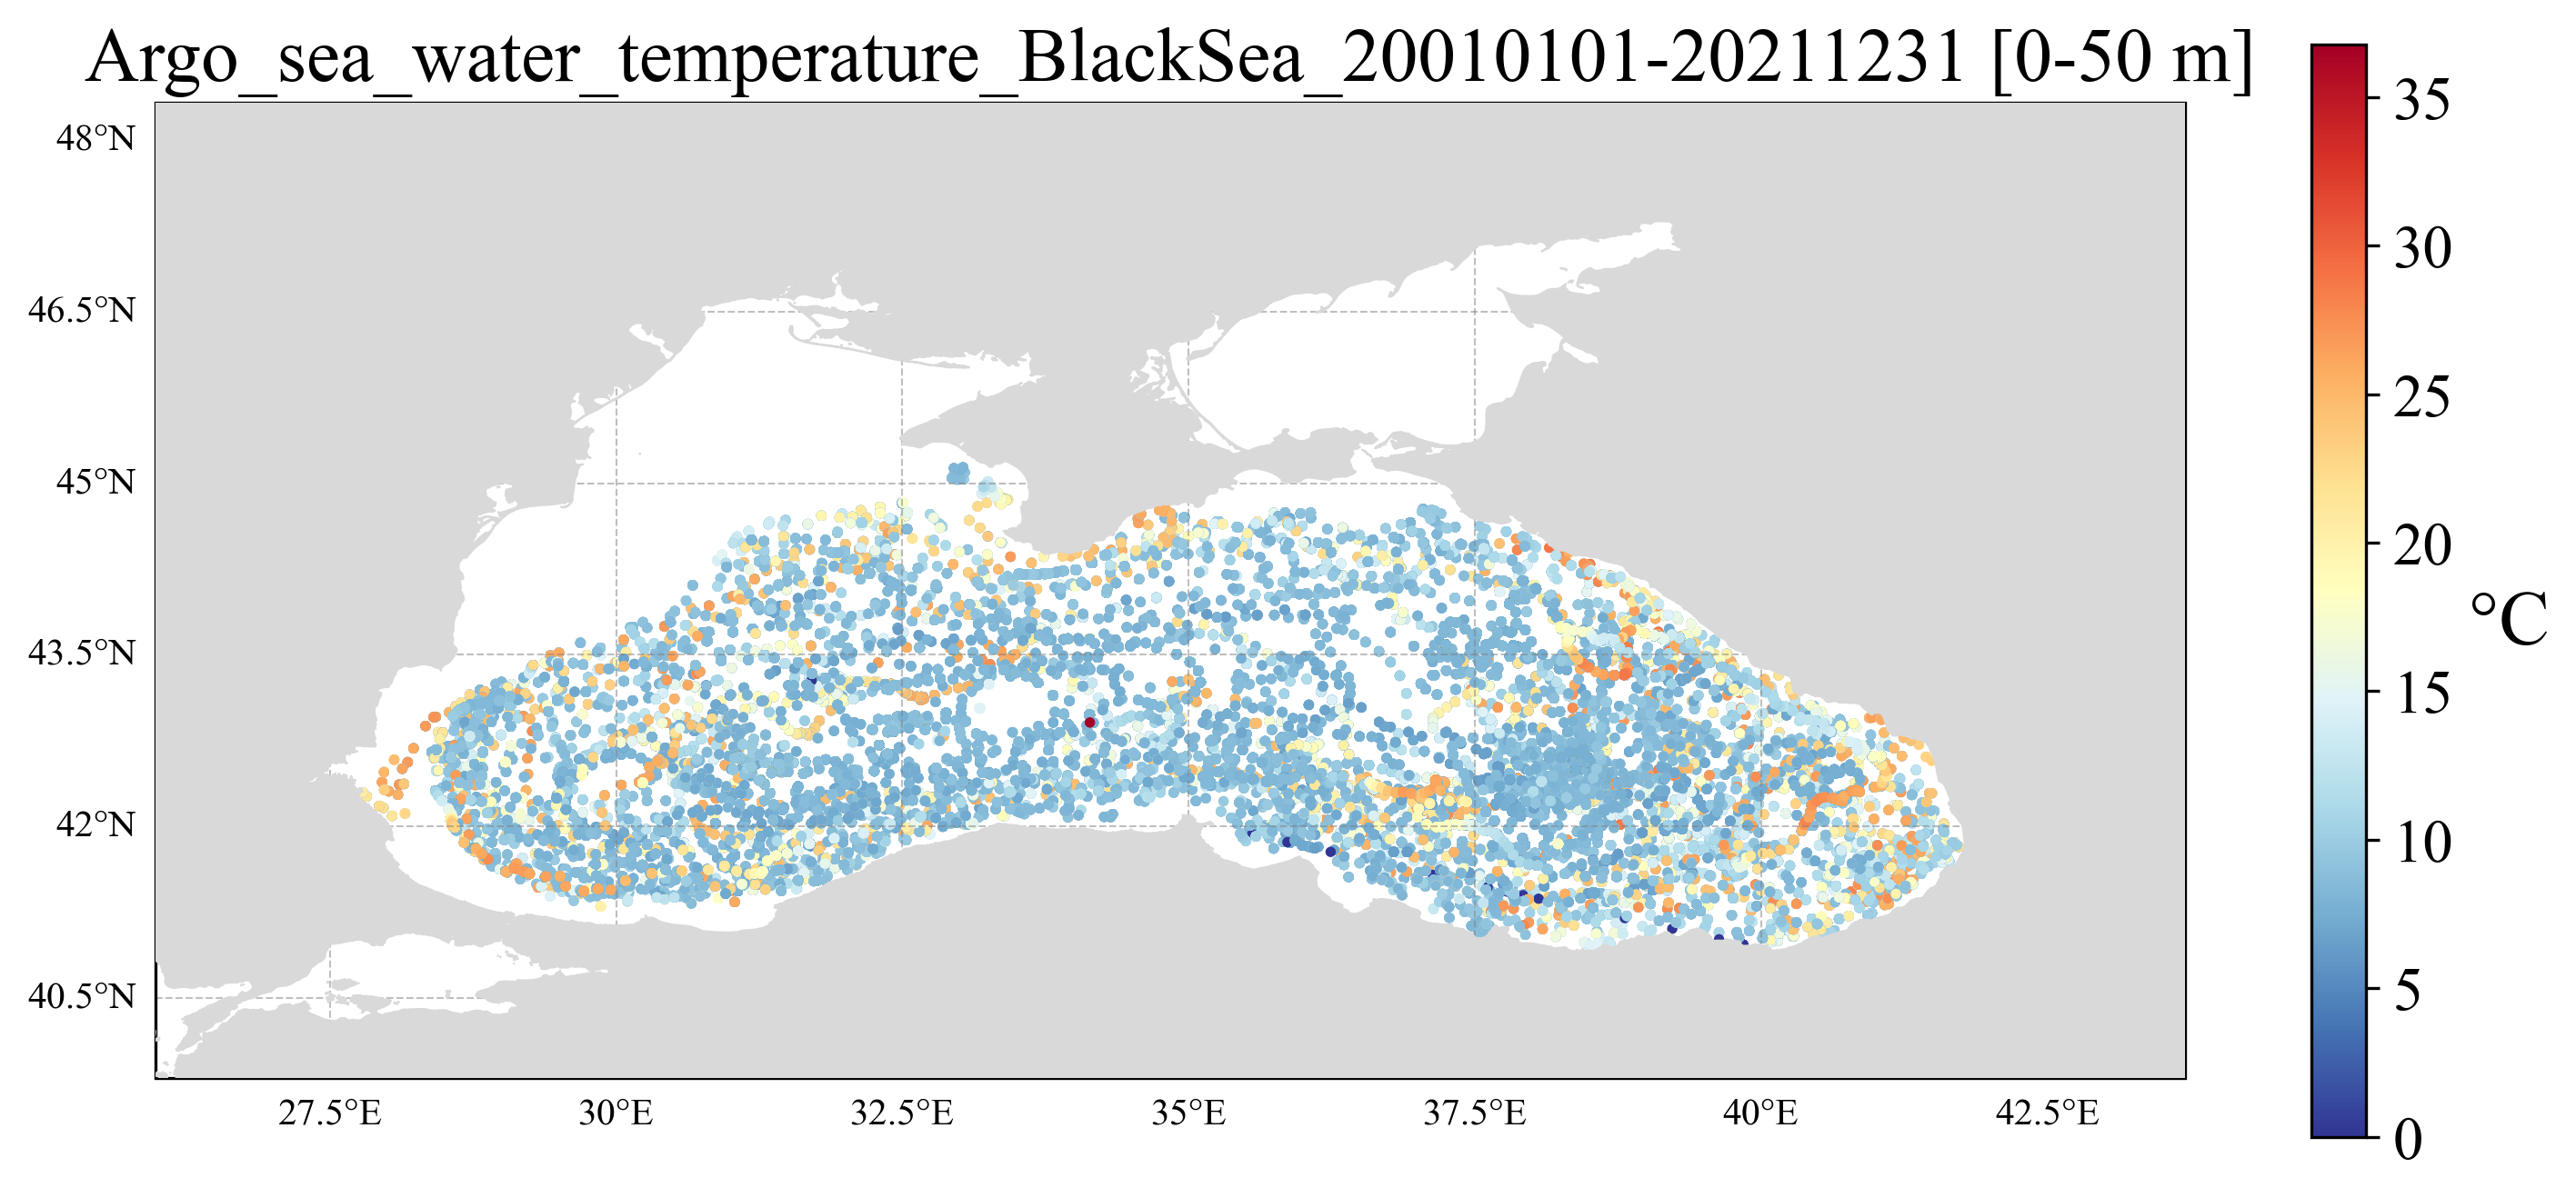

In [52]:
fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([minlon, maxlon, minlat, maxlat])
scat = ax.scatter(obslon, obslat, s=3, c=obsval, cmap=plt.cm.RdYlBu_r)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                  linewidth=.5, color="gray", alpha=0.5, linestyle="--", zorder=3)
ax.add_feature(coast, lw=.5, color=".85", zorder=4)
gl.top_labels = false
gl.right_labels = false
ax.set_title(figtitle)

cbar = plt.colorbar(scat, shrink=.65)
cbar.set_label("°C", rotation=0, ha="left")
plt.show()

### With Basemap

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


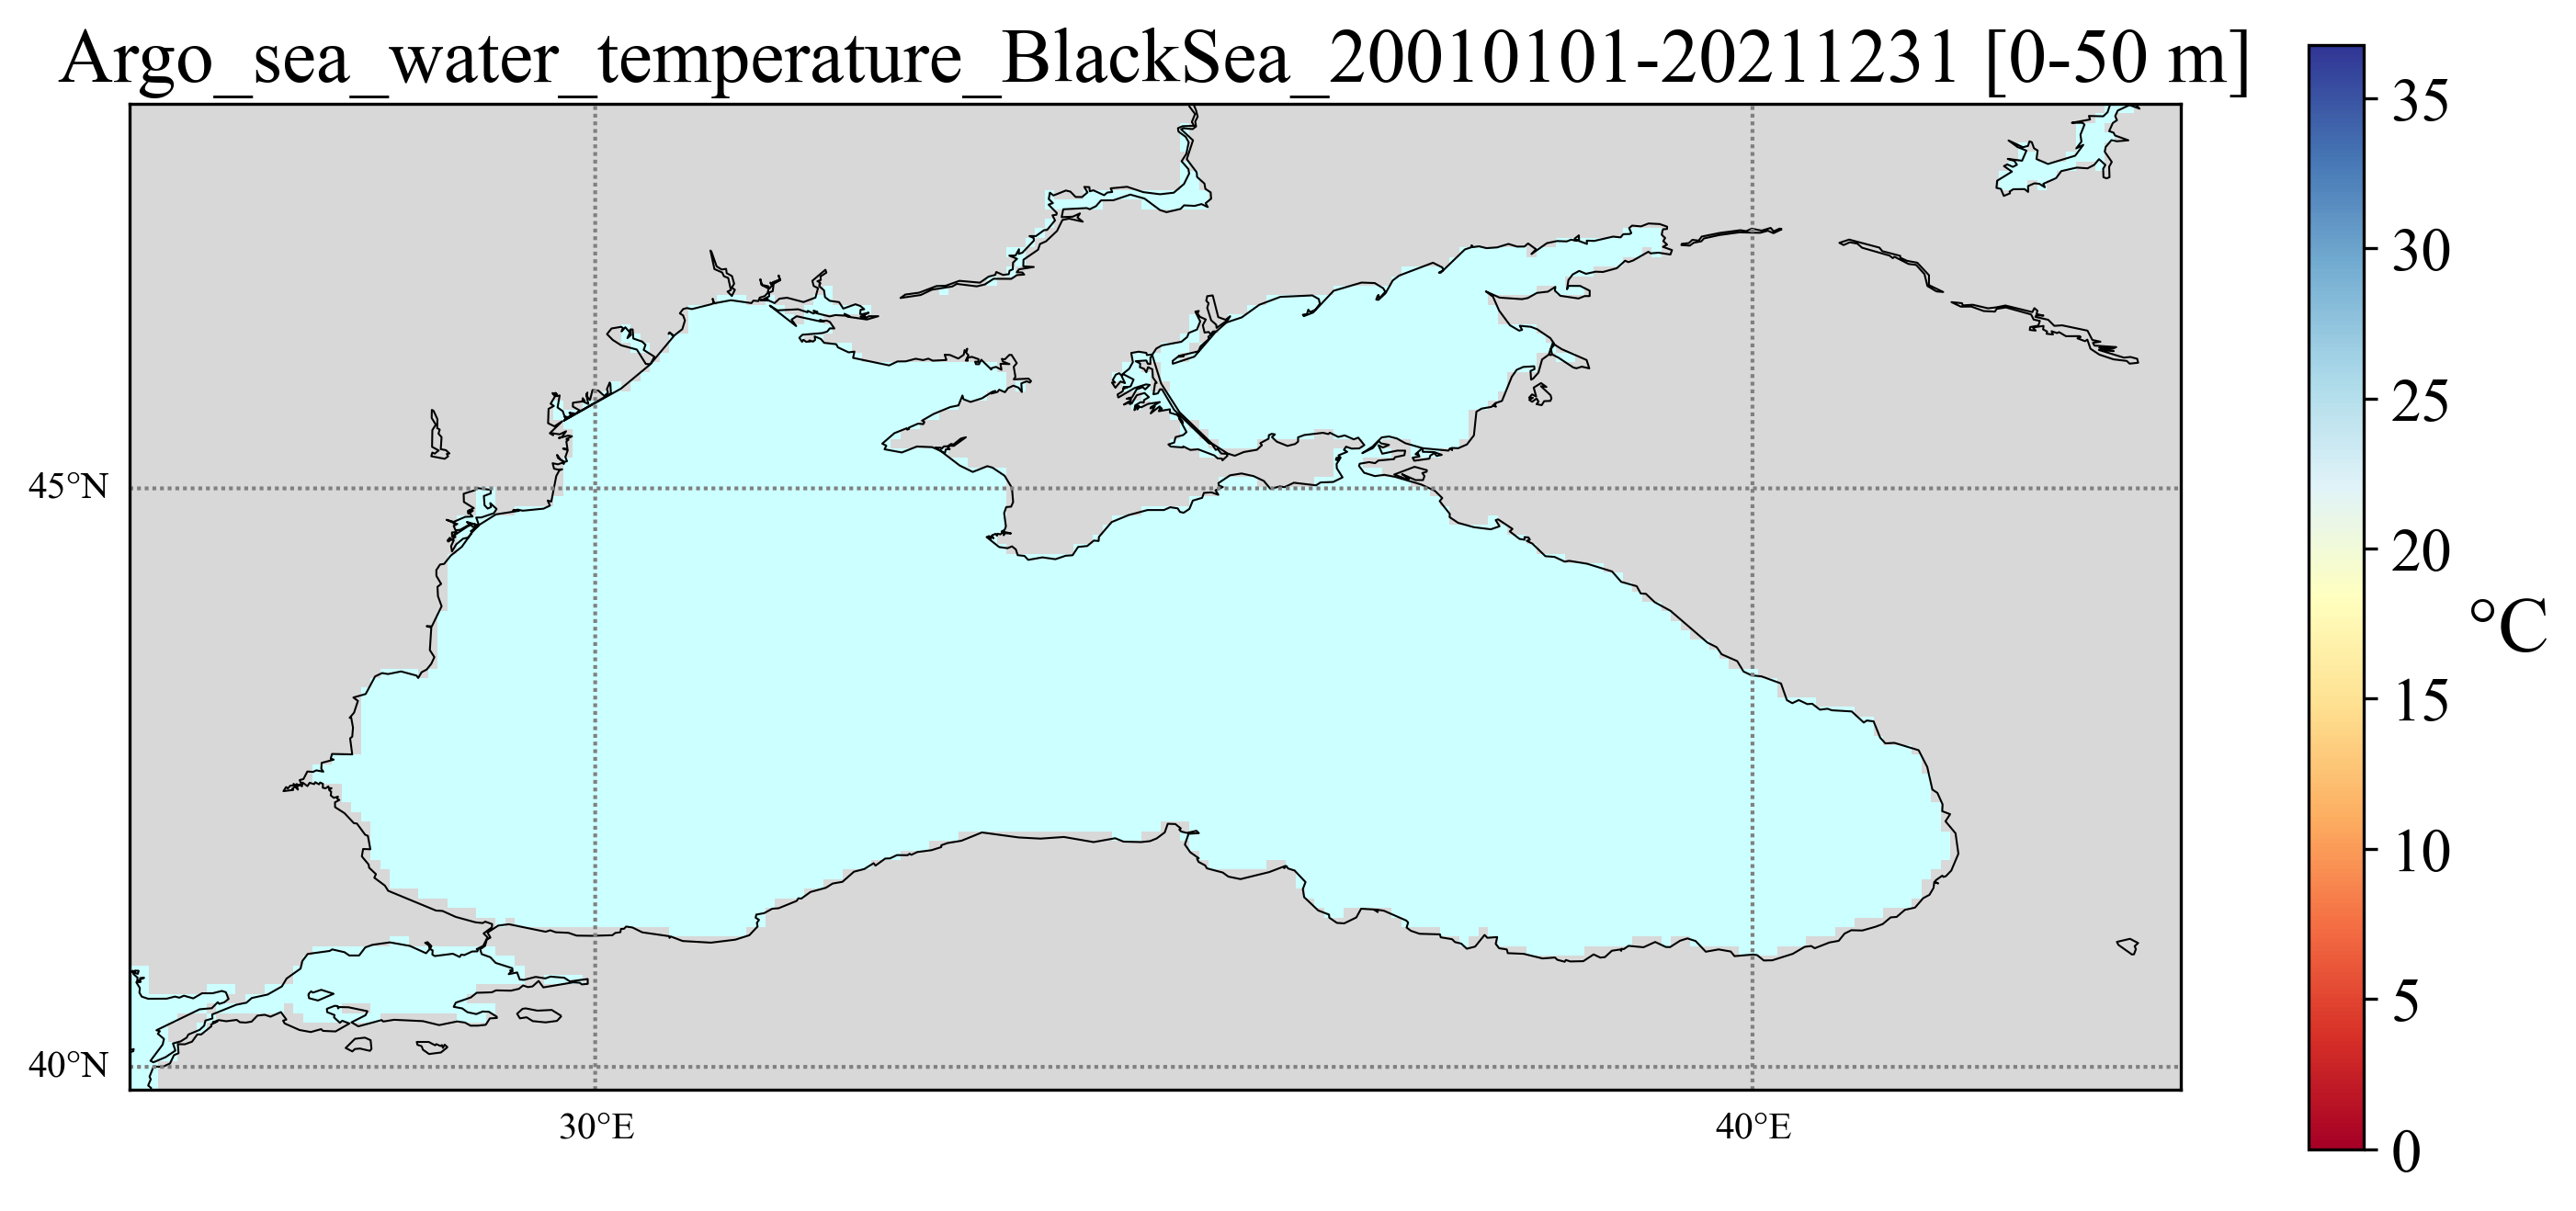

In [54]:
fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(111)

m = Basemap(projection = "cyl", llcrnrlon = minlon, llcrnrlat = minlat, 
    urcrnrlon = maxlon, urcrnrlat = maxlat, resolution = "i") 
m.drawlsmask(land_color = ".85", ocean_color = "#CCFFFF"); # can use HTML names or codes for colors
m.drawcoastlines(linewidth=.5)
m.drawparallels(collect(0.:5.:90.), color="gray", labels=[1,0,0,0])
m.drawmeridians(collect(-10.:10.:80.), color="gray", labels=[0,0,0,1])

# Plot points
scat = m.scatter(obslon, obslat, latlon=true, s=3, c=obsval, cmap=plt.cm.RdYlBu)
ax.set_title(figtitle)
cbar = plt.colorbar(scat, shrink=.65)
cbar.set_label("°C", rotation=0, ha="left")
plt.show()

## DIVAnd analysis

In [58]:
using DIVAnd

### Set grid
- resolution
- extent
- depth levels

In [59]:
dx, dy = 0.25, 0.25
lonr = minlon:dx:maxlon
latr = minlat:dy:maxlat
timerange = [datestart, dateend];

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 60., 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];

# Take only depth levels above the maximal depth in the observations
depthr = depthr[depthr .<= maxdepth];

### Time periods
We take all the years together and create 4 time periods, corresponding to seasons.    

In [61]:
yearlist = [Dates.year(datestart):Dates.year(dateend)];
monthlist = [[1,2,3], [4,5,6], [7,8,9], [10,11,12]];
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = TimeSelectorYearListMonthList{Vector{UnitRange{Int64}}, Vector{Vector{Int64}}}(UnitRange{Int64}[2001:2021], [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])


### Analysis parameters
- correlation length (along lon, lat and depth)
- noise-to-signal ratio

In [62]:
sz = (length(lonr), length(latr), length(depthr));
lenx = fill(100_000.,sz)   # 100 km
leny = fill(100_000.,sz)   # 100 km
lenz = fill(5.,sz);      # 25 m 
len = (lenx, leny, lenz);
epsilon2 = 0.1;

### Output file name

In [63]:
outputfile = joinpath(outputdir, "Argo_DIVAnd_$(parameter)_$(regionname)_$(Dates.format(datestart, "yyyymmdd"))-$(Dates.format(dateend, "yyyymmdd"))_$(Int(mindepth))-$(Int(maxdepth))m.nc")

"../output/Argo_DIVAnd_sea_water_temperature_BlackSea_20010101-20211231_0-50m.nc"

### Bathymetry
We work with the GEBCO bathymetry with a decreased resolution         
(full resolution not needed for this application).

In [65]:
bathname = joinpath(datadir, "gebco_30sec_16.nc")
isfile(bathname) ? @debug("Bathymetry file already downloaded") : download("https://dox.uliege.be/index.php/s/U0pqyXhcQrXjEUX/download", bathname)

### Helper function to generate plots

In [66]:
function makemap(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        plt.figure()
        ax = plt.subplot(111, projection=ccrs.PlateCarree())
        ax.set_extend([lonr[1], lonr[end], latr[1], latr[end]])
        pcm = ax.pcolormesh(lonr, latr, permutedims(tmp[:,:,i], [2,1]), cmap=plt.cm.RdYlBu_r)
        cb = plt.colorbar(pcm, extend="both", orientation="vertical", shrink=0.8)
        cb.set_label("°C", rotation=0, ha="left")
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                  linewidth=.5, color="gray", alpha=0.5, linestyle="--", zorder=3)
        ax.add_feature(coast, lw=.5, color=".85", zorder=4)
        gl.top_labels = false
        gl.right_labels = false
        
        ax.set_title("Depth: $(depthr[i]) \n Time index: $(timeindex)")
        
        figname = parameter * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        plt.savefig(joinpath(figdir, figname));
        plt.close_figs()
    end
end

makemap (generic function with 1 method)

### Run analysis

In [67]:
@time dbinfo = diva3d((lonr, latr, depthr, TS),
    (obslon,obslat,obsdepth,obsdates), obsval,
    len, epsilon2,
    outputfile,parameter,
    bathname=bathname,
    fitcorrlen = false,
    niter_e = 2,
    surfextend = true
    );

[ Info: Creating netCDF file ../output/Argo_DIVAnd_sea_water_temperature_BlackSea_20010101-20211231_0-50m.nc
[ Info: Time step 1 / 4
[ Info: scaled correlation length (min,max) in dimension 1: (100000.0, 100000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (100000.0, 100000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (5.0, 5.0)
┌ Warning: resolution (5.0) is too coarse for correlation length 5.0 in dimension 3 at indices CartesianIndex(1, 1, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: number of windows: 1
┌ Warning: resolution (5.0) is too coarse for correlation length 5.0 in dimension 3 at indices CartesianIndex(1, 1, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/EG6qD/src/utils.jl:18
[ Info: numbe

 39.429457 seconds (74.61 M allocations: 15.537 GiB, 10.16% gc time, 84.25% compilation time)


## Plot the results
### Read from the netCDF

In [69]:
@time lon, lat, depth, times, field = ArgoFairEase.get_results(outputfile, parameter);

  0.011606 seconds (205.57 k allocations: 4.952 MiB)


### Winter period

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


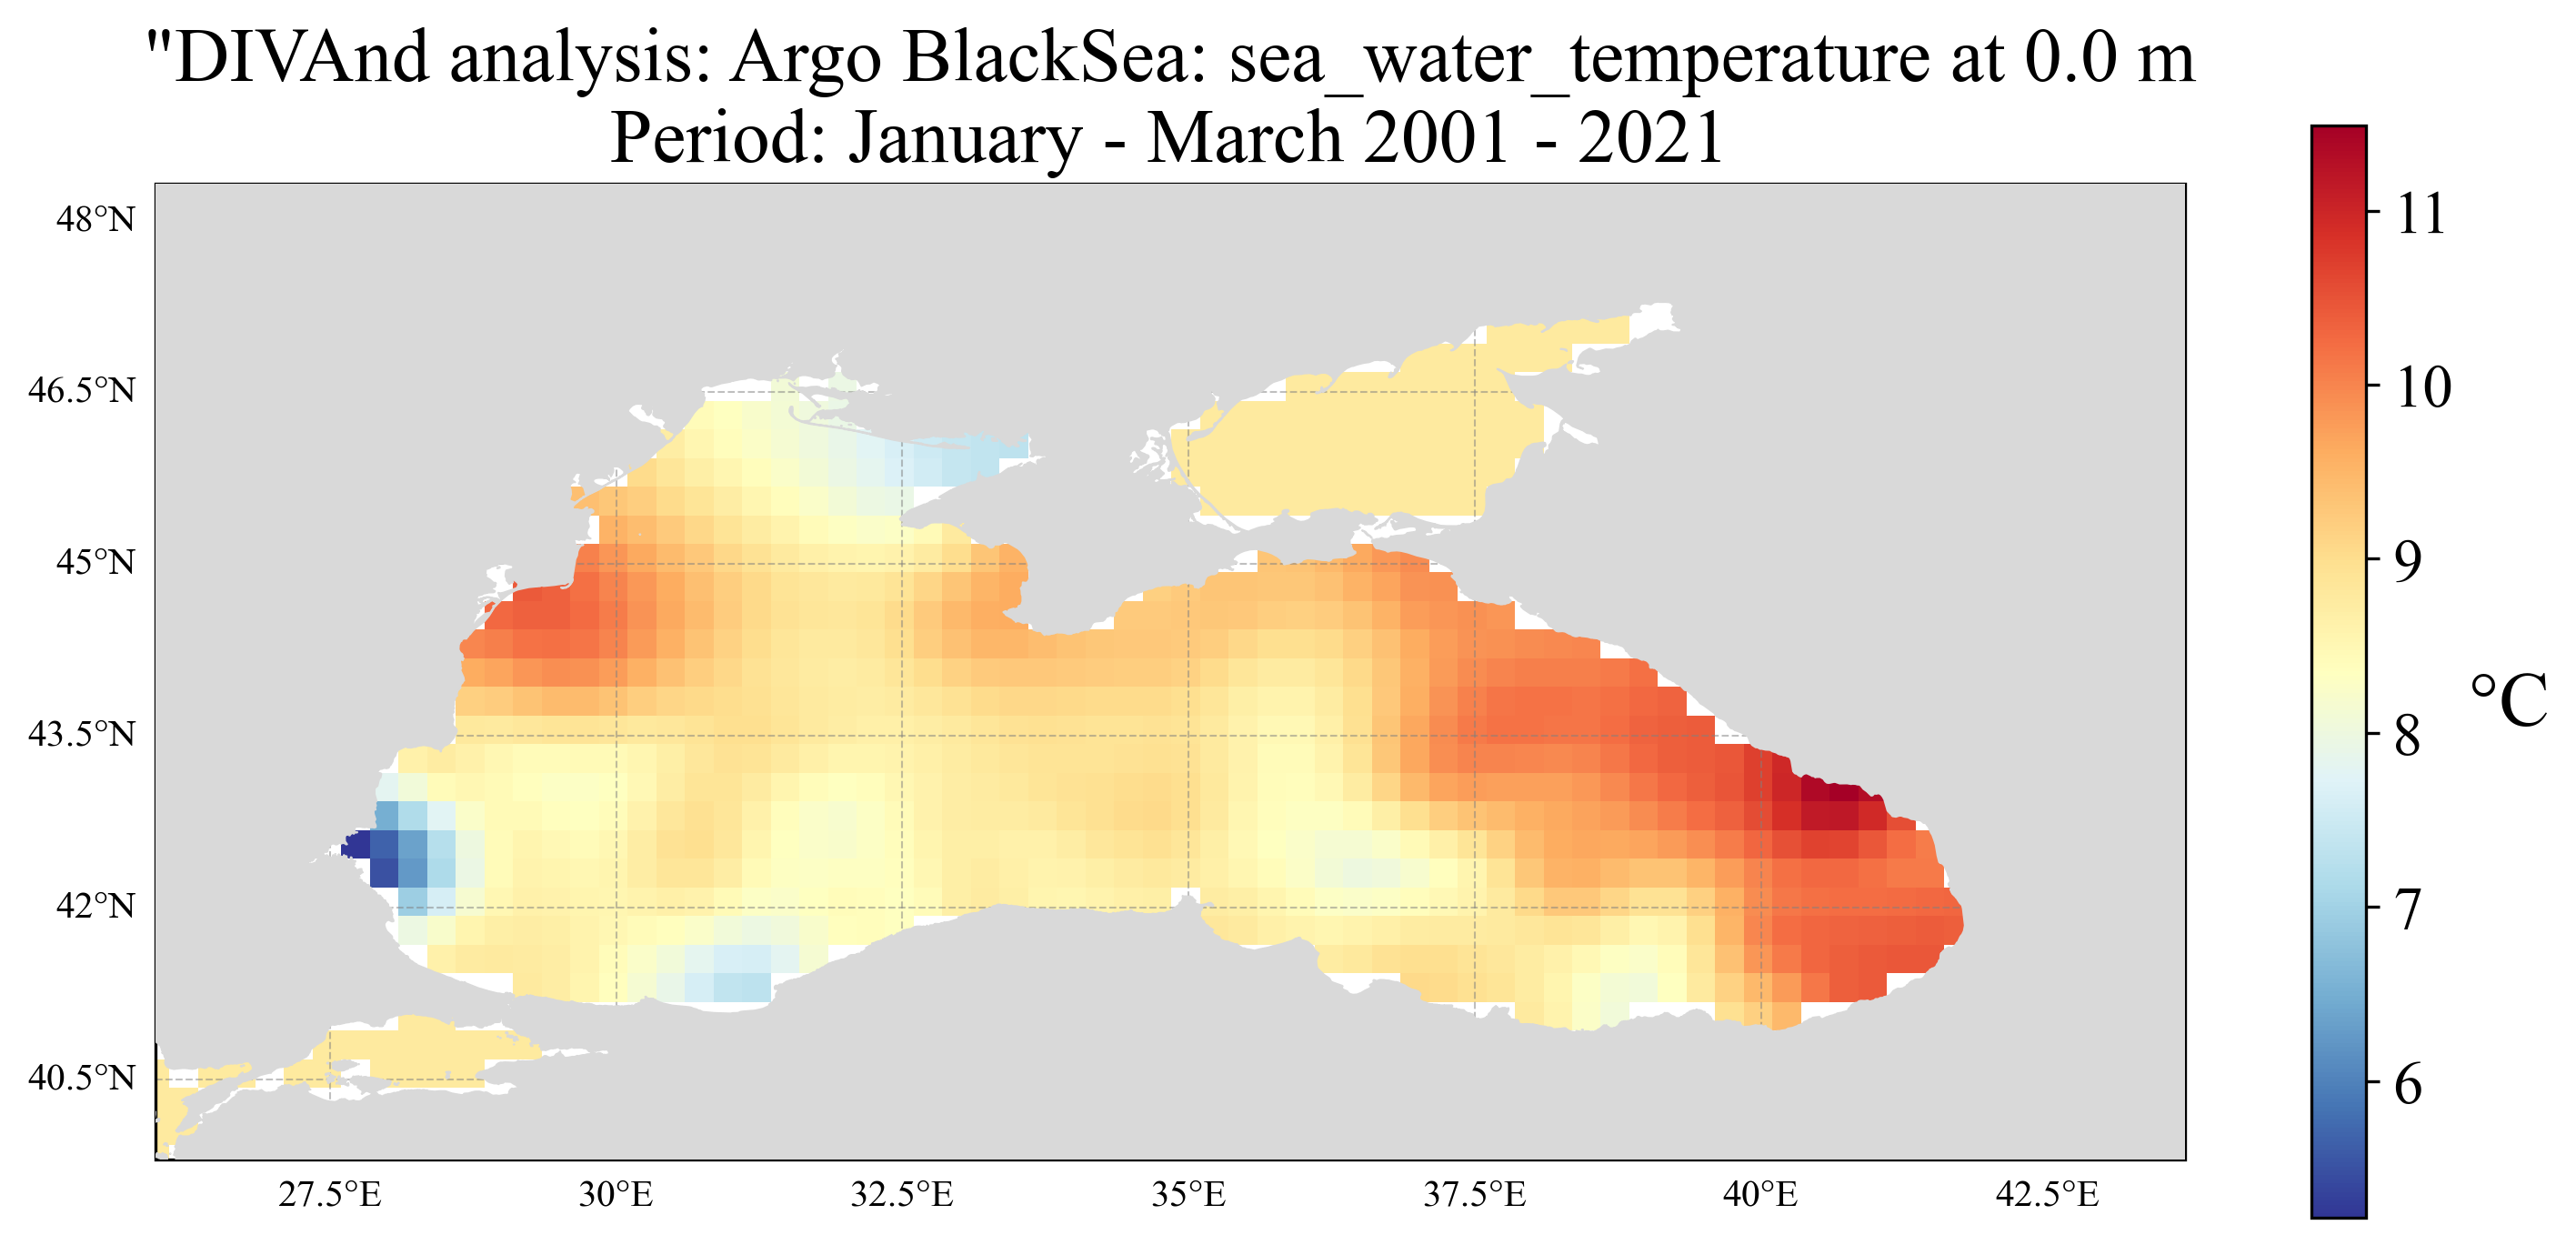

In [70]:
figtitle = """
"DIVAnd analysis: Argo $(regionname): $(parameter) at $(depthr[1]) m
Period: $(Dates.monthname(monthlist[1][1])) - $(Dates.monthname(monthlist[1][end])) $(yearlist[1][1]) - $(yearlist[1][end])"""

fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([minlon, maxlon, minlat, maxlat])
pcm = ax.pcolormesh(lon, lat, field[:,:,1,1]', cmap=plt.cm.RdYlBu_r)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                  linewidth=.5, color="gray", alpha=0.5, linestyle="--", zorder=3)
ax.add_feature(coast, lw=.5, color=".85", zorder=4)
gl.top_labels = false
gl.right_labels = false
ax.set_title(figtitle)

cbar = plt.colorbar(pcm, shrink=.65)
cbar.set_label("°C", rotation=0, ha="left")
plt.show()

### Summer period

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


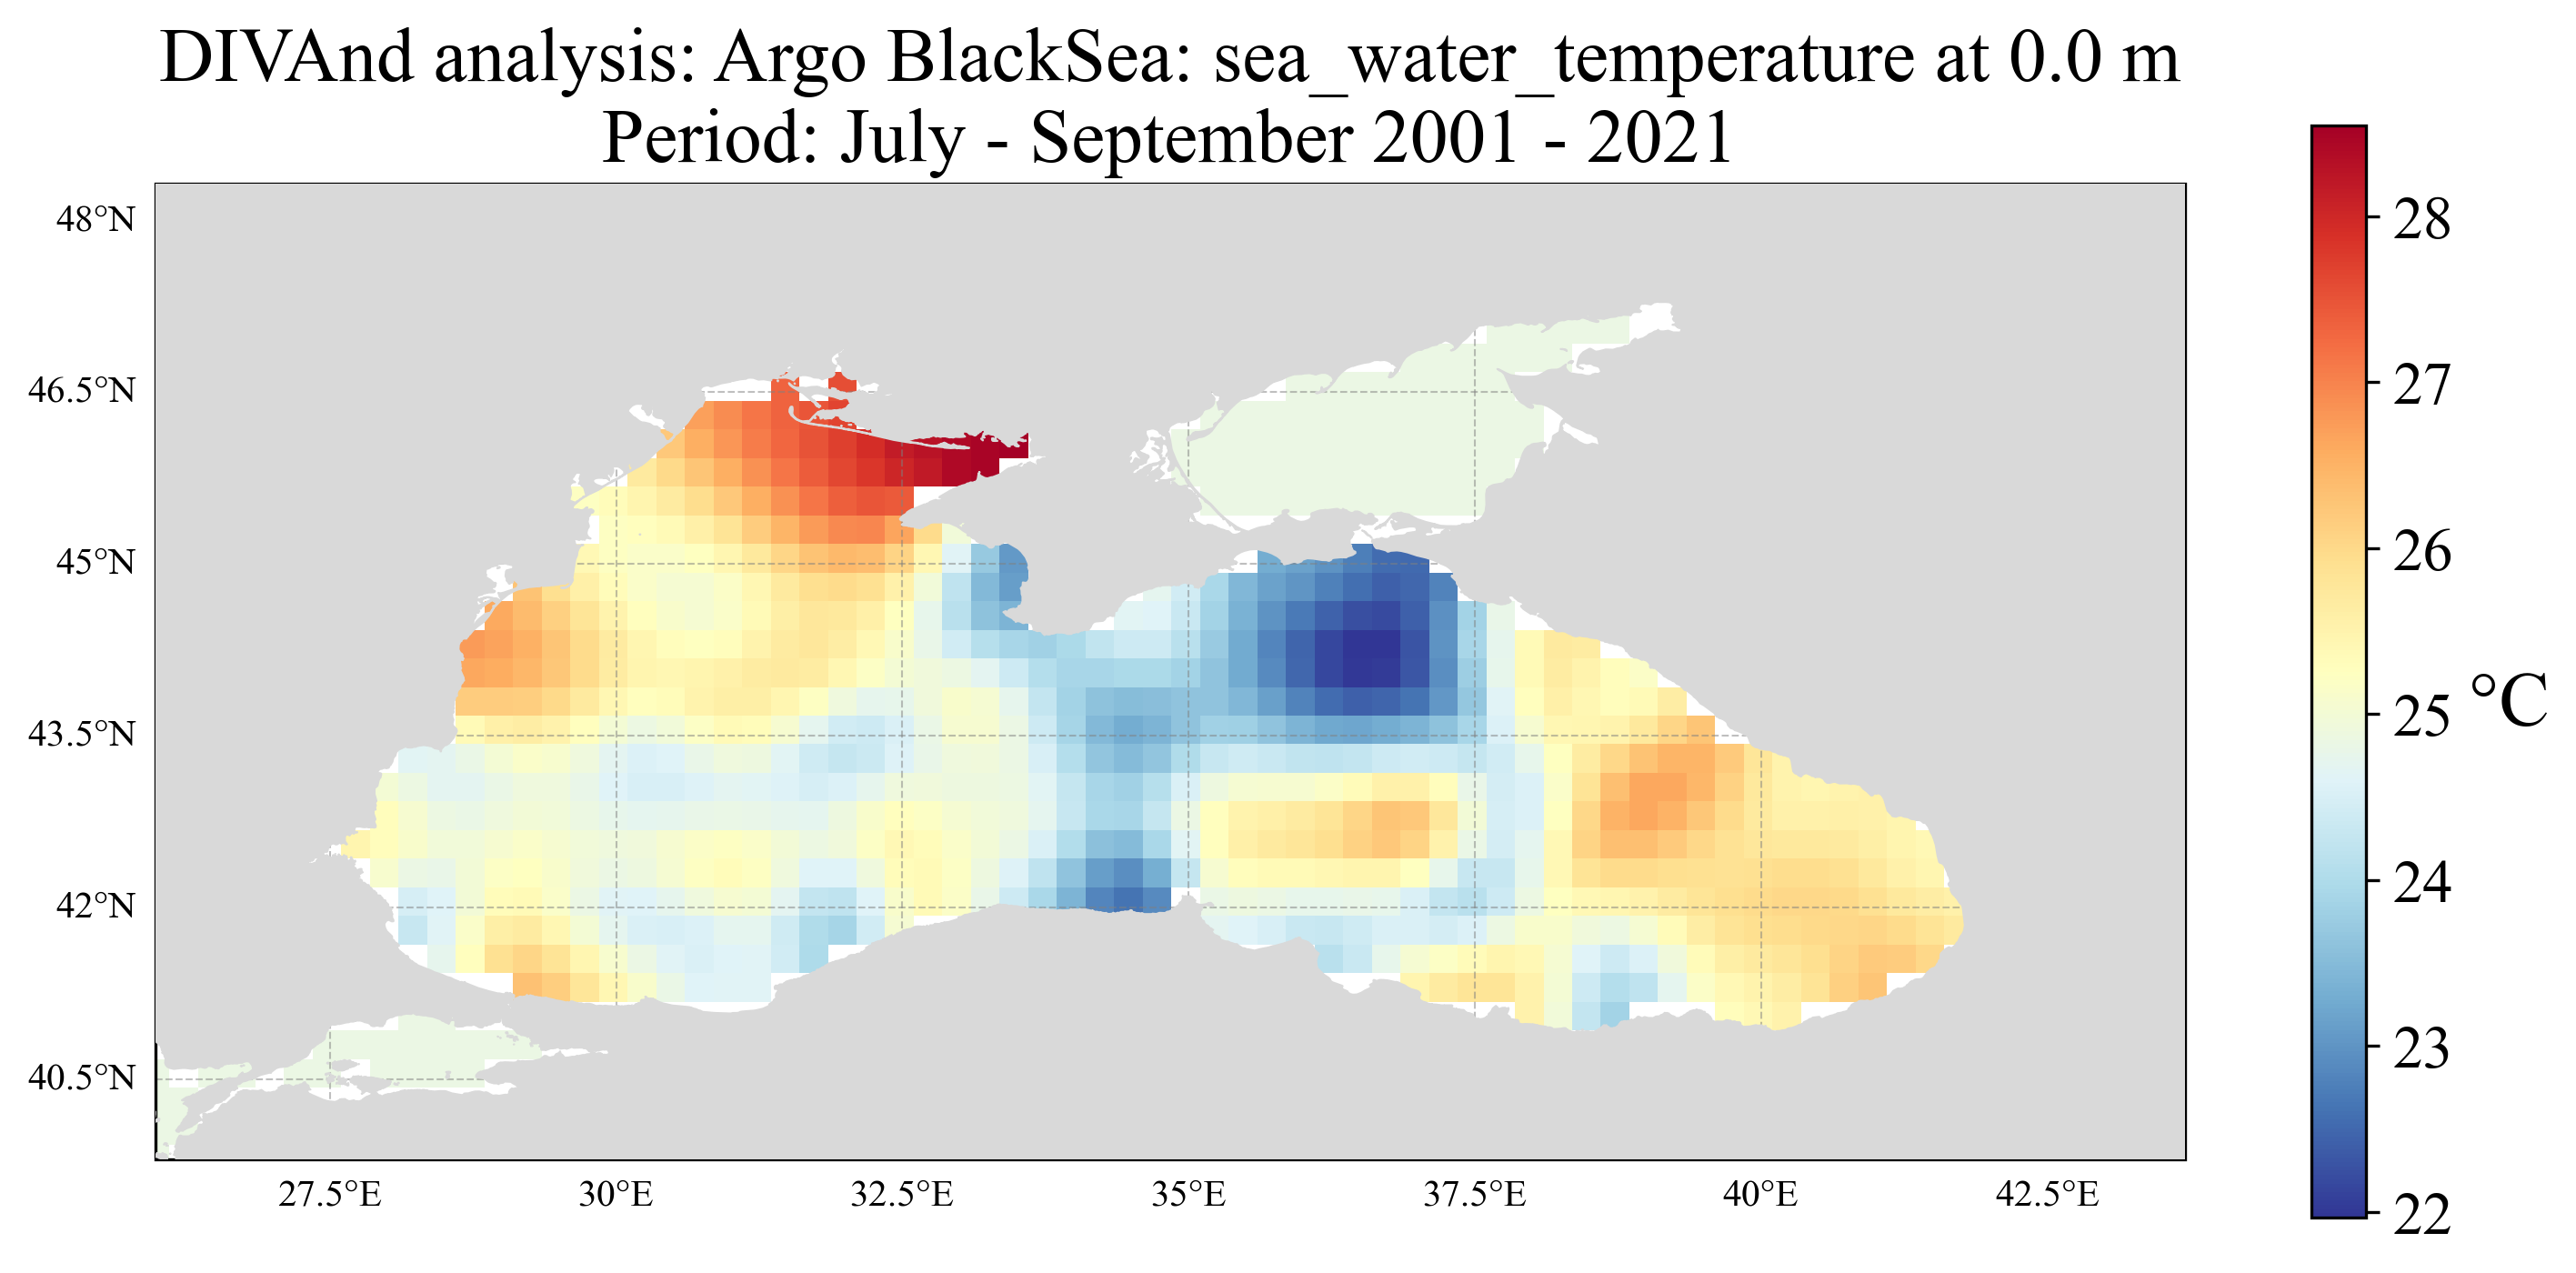

In [71]:
figtitle = """
DIVAnd analysis: Argo $(regionname): $(parameter) at $(depthr[1]) m
Period: $(Dates.monthname(monthlist[3][1])) - $(Dates.monthname(monthlist[3][end])) $(yearlist[1][1]) - $(yearlist[1][end])"""

fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([minlon, maxlon, minlat, maxlat])
pcm = ax.pcolormesh(lon, lat, field[:,:,1,3]', cmap=plt.cm.RdYlBu_r)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                  linewidth=.5, color="gray", alpha=0.5, linestyle="--", zorder=3)
ax.add_feature(coast, lw=.5, color=".85", zorder=4)
gl.top_labels = false
gl.right_labels = false
ax.set_title(figtitle)

cbar = plt.colorbar(pcm, shrink=.65)
cbar.set_label("°C", rotation=0, ha="left")
plt.show()